In [1]:
import os
from glob import glob

In [2]:
#from dask import delayed
#from dask import compute
#from dask.distributed import Client, progress
#client = Client(threads_per_worker=4, n_workers=20)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from root_pandas import read_root 
from ROOT import TFile

Welcome to JupyROOT 6.16/00


/home/jcordero/CMS/SMP_ZGamma/envSMP/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [4]:
'''
from guppy import hpy
h = hpy()
print(h.heap())
''';

In [5]:
from Common.CommonHelper  import CommonHelper
from Config.ConfigManager import ConfigManager
from Samples.DataSample   import DataSample
from Samples.DataFile     import DataFile
from Samples.Event        import Event
from Samples.DataFile     import DataFile
from Samples.ConfigData   import ConfigData
from Cuts.Cuts            import Cuts
from Plotter.Histo        import Histo
from Plotter.HistoSample  import HistoSample
from Plotter.HistoVar     import HistoVar

In [6]:
def getSamplesPath(path):
    return glob(os.path.join(path,"*[!.][!s][!h]"))

def getSampleFromPath(path):
    return path.split("/")[-1]

def getFileFromPath(path):
    return path.split("/")[-1]

def getFiles(path,sample):
    return glob(os.path.join(path,sample,"output*[!v_0]*"))

In [7]:
def isPathEmpty(path,samp):
    file = glob(os.path.join(path, getSampleFromPath(samp),"output*"))
    if file:
        return False
    else:
        return True

In [8]:
def FillLoop(Sample, HStack, Cut):    
    for file in Sample:
        for i,iEvent in enumerate(file):
            #if i == 1:break
            event = Event(iEvent)
            event = Event(event[Cut.Pass(event,Region=None)])
            for histo in HStack:
                histo.fill( event.value(histo.name),
                            event.value('eventWeight')*Sample.getSF())
    return HStack

In [9]:
Manager = ConfigManager()

selection = "mumug"
era = "2018"
#era = "2017"

histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
Manager.CreateProject(histsavepath)
Manager.CreateProject(figpath)

path = "/home/jcordero/CMS/data/data_{}/rereco/SMP_ZG/Files/{}/VDask/".format(era,selection)
histsavepath += "{}/{}/{}/".format(Manager.Date(),era,selection)
figpath += "{}/{}/{}/".format(Manager.Date(),era,selection)

chuncksize = 5000

Cut = Cuts(PhotonRadiation = "ISR", OppositeCharge = True, VetoDY = True)

In [10]:
DSample = DataSample()

for samp in getSamplesPath(path):
    if not isPathEmpty(path,samp) :
        DSample.append( DataFile(path, getSampleFromPath(samp), era, chuncksize) )
    

In [11]:

HSampleStack = HistoSample()
HVarStack = HistoVar()
for sample in DSample.getSamples():
    print(sample)
    HSampleStack.append(FillLoop(DSample[sample], HVarStack.initialize(), Cut), sample)
    

WZTo2L2Q
DYJets
ZZTo4L
DoubleMuon_2018A
DoubleMuon_2018B
DoubleMuon_2018D
ZGToLLG
TTTo2L2Nu
DoubleMuon_2018C
WZTo3LNu
WJets


In [12]:
DoubleMuon = ['DoubleMuon_{}{}'.format(era,run) for run in ConfigData.Runs(era)]
HSampleStack.merge(DoubleMuon,name ="DoubleMuon")
HSampleStack.merge(ConfigData.Diboson(era),name ="Diboson")

/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:158: RuntimeWarning: divide by zero encountered in true_divide
  Ratio = Data/MC
/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:160: RuntimeWarning: divide by zero encountered in true_divide
  err = Data/MC*(np.sqrt(1/Data + 1/MC))
/home/jcordero/CMS/SMP_ZGamma/envSMP/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


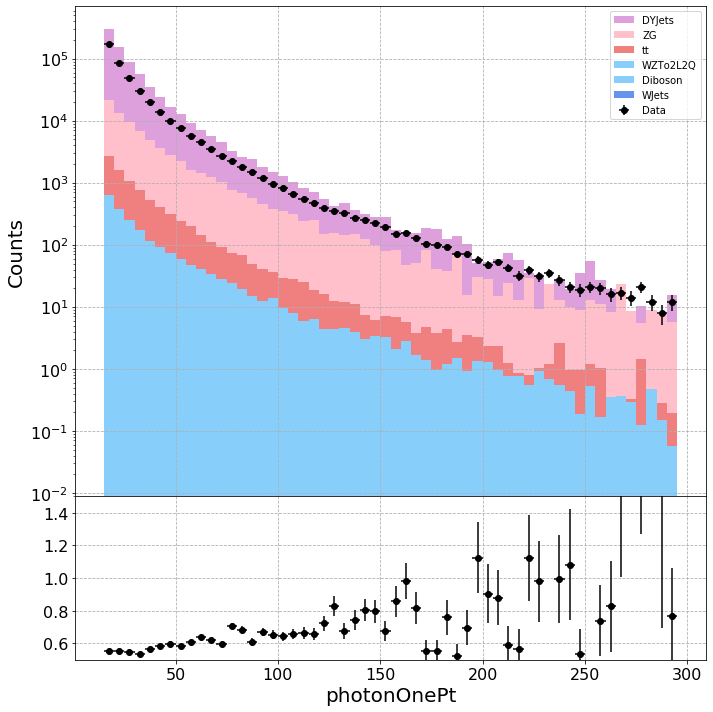

In [13]:
variable = 'photonOnePt'
HS = HSampleStack.plot(variable=variable,log=True)#,Debug=True)
fig = HS[0]

In [14]:
#HSampleStack.save(path = histsavepath)
HSampleStack.savefig(fig,figpath+variable)